In [1]:
# Convert a Classical Neuron to a Finite Gaussian Neuron and back
#  version that checks that it works for NLL loss

In [2]:
from __future__ import print_function
import numpy as np

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

In [5]:
# random seeds
torch.manual_seed(665)
np.random.seed(3326)

torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(999)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
### PART 1
# math and visual proof 

# scale of the heat maps
X1 = np.arange(-8,8.1, 0.1)
X2 = np.arange(-8,8.1, 0.1)
X1s, X2s = np.meshgrid(X1,X2)
inputs_heatmap = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(inputs_heatmap))
# print(inputs_heatmap)

shape of heatmap (25921, 2)


In [7]:
num_dim = 2

# classical neuron params
W = np.array([7.0, -1.0])
b = -7.0

# WX+b = 0 line
zero_line = -(W[0]*X1+b)/W[1]

# orthogonal line
ortho_line = W[1]*X1 / W[0]

# point closest to origin will be new centers
centers = (-b/np.dot(W,W))*W
print(centers)

# sig equal to input dim
sig = num_dim

# backwards 
b = -np.dot(W,centers)
print("b=", b)

[ 0.98 -0.14]
b= -7.0


In [8]:
# heatmap neuronal activity
n_activity = np.sum(W*inputs_heatmap, axis=1)+b
print(n_activity.shape)

# heatmap radial activity 
r_activity = np.exp((-1.0/sig**2) *  np.sum(np.square(inputs_heatmap-centers), axis=1))
print(r_activity.shape)

# overall heatmap activity
activity = n_activity*r_activity

(25921,)
(25921,)


<IPython.core.display.Javascript object>


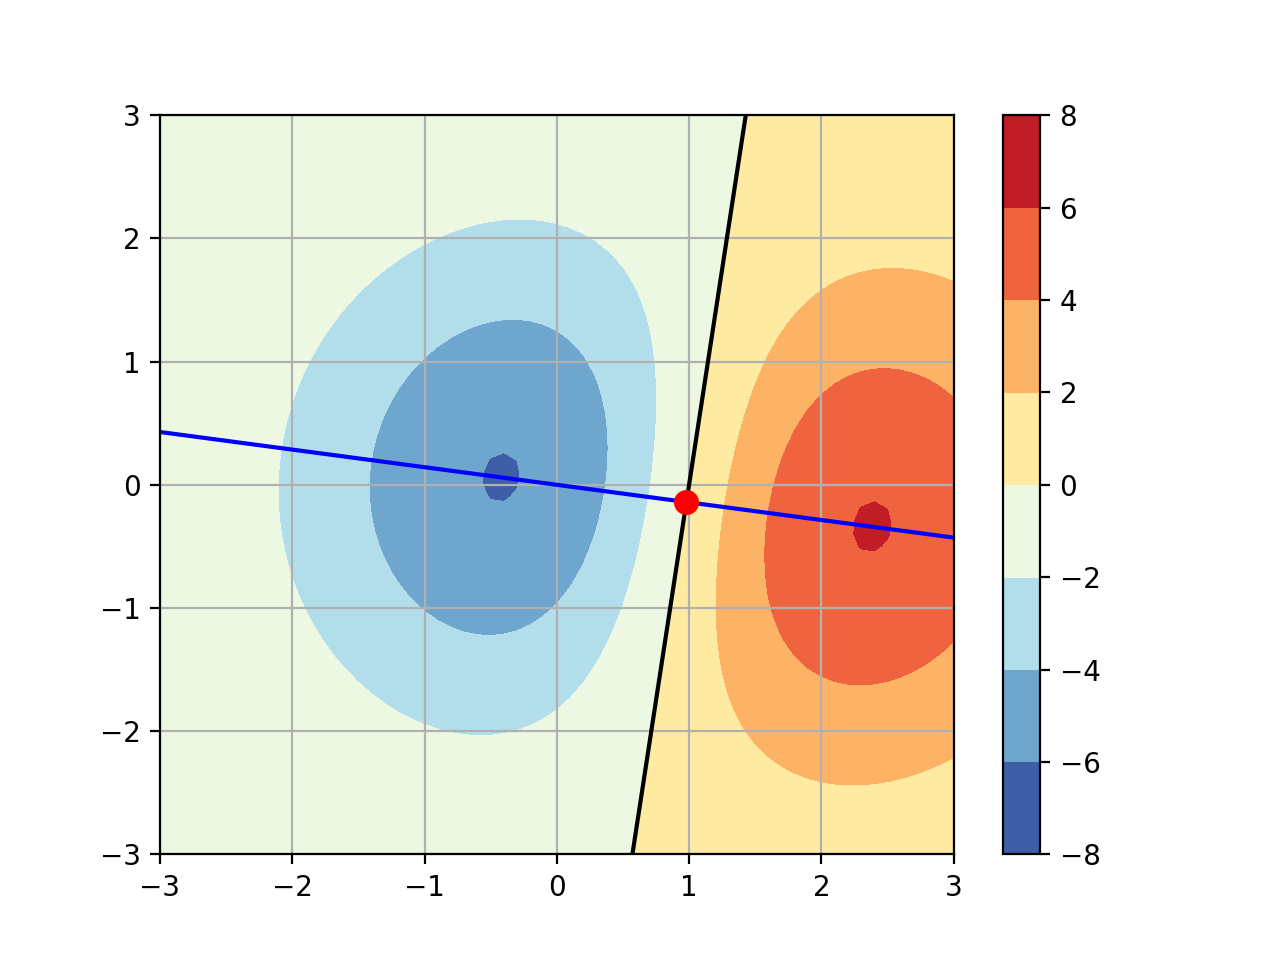

In [9]:
# plot the zero line
plt.plot(X1,zero_line, color='black')
plt.plot(X1,ortho_line, color='blue')
plt.plot(centers[0], centers[1], marker='o', markersize=8, color="red")

# levels = 2*np.arange(-sig,sig+0.1,sig/10.0)
# ticks = 2*np.arange(-sig,sig+1, sig/5.0)

# plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=levels, cmap=cm.RdYlBu_r)
plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), cmap=cm.RdYlBu_r)

# plt.colorbar(ticks=ticks)
plt.colorbar()
#reset axes
plt.axis([-3,3, -3, 3])
plt.grid(True)
plt.show()

In [10]:
### Part 2 - test conversion

In [11]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 10

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 500

samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
# (labels are class number)
num_classes = 2
samples_labels = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs, sep_plane)])

In [12]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [13]:
# Define a Finite Gaussian Neural Network
class ClassicNet(nn.Module):
    def __init__(self):
        super(ClassicNet, self).__init__()
        self.l1 = nn.Linear(num_dim,num_classes)
        
    def forward(self, x):
        x = self.l1(x)
        # clip res to +1
        x = F.softmax(x, dim=-1)
        return x

In [14]:
# Initialize the network
classic_model = ClassicNet().to(device)

In [15]:
for m in classic_model.modules():
    print(m)

ClassicNet(
  (l1): Linear(in_features=10, out_features=2, bias=True)
)
Linear(in_features=10, out_features=2, bias=True)


In [16]:
# classic loss function
def classic_loss_func(model, output, target):
    return F.nll_loss(output, target.long())

In [17]:
# number of correct pred function
def pred_func(output, target):
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [18]:
# optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, classic_model.parameters()), lr=0.01, momentum=0.5, nesterov=True)

In [19]:
# train the model
epochs = 50
classic_train_res = th.train(classic_model, device, my_dataloader, classic_loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: -0.5175, Accuracy: 209/400 (52%)
Test set - Average loss: -0.5196, Accuracy: 48/100 (48%)
Epoch 1 Train set - Average loss: -0.5310, Accuracy: 221/400 (55%)
Test set - Average loss: -0.5330, Accuracy: 53/100 (53%)
Epoch 2 Train set - Average loss: -0.5459, Accuracy: 235/400 (59%)
Test set - Average loss: -0.5475, Accuracy: 57/100 (57%)
Epoch 3 Train set - Average loss: -0.5615, Accuracy: 244/400 (61%)
Test set - Average loss: -0.5625, Accuracy: 60/100 (60%)
Epoch 4 Train set - Average loss: -0.5771, Accuracy: 260/400 (65%)
Test set - Average loss: -0.5772, Accuracy: 64/100 (64%)
Epoch 5 Train set - Average loss: -0.5918, Accuracy: 269/400 (67%)
Test set - Average loss: -0.5910, Accuracy: 68/100 (68%)
Epoch 6 Train set - Average loss: -0.6052, Accuracy: 282/400 (70%)
Test set - Average loss: -0.6037, Accuracy: 73/100 (73%)
Epoch 7 Train set - Average loss: -0.6174, Accuracy: 292/400 (73%)
Test set - Average loss: -0.6151, Accuracy: 74/100 (74%)
Epoch 8 

In [20]:
# check some values
print(classic_model.state_dict())

OrderedDict([('l1.weight', tensor([[ 0.0294, -0.6837, -0.1129,  0.1478, -0.0652,  0.4240, -0.3257,  0.1864,
         -0.7039,  0.6560],
        [-0.5729,  0.6402, -0.1709, -0.2897, -0.0121, -0.4337,  0.3643,  0.1854,
          0.7344, -0.3539]], device='cuda:0')), ('l1.bias', tensor([-0.0298, -0.3555], device='cuda:0'))])


In [21]:
# convert to FGN network

In [22]:
# function that will convert state dicts 

def convert_state_dict_lin2FGN(lin_state_dict, fgn_state_dict):
    # given the state dict of a nn.Linear layer, and the fgn_state_dict (for the names)
    # returns a state dict for FGNlayer
    
    weights = lin_state_dict.values()[0]
    bias = lin_state_dict.values()[1]
    
    new_centers =  torch.Tensor([(-b/np.dot(x,x))*x for x,b in zip(weights.cpu().detach().numpy(), bias.cpu().detach().numpy())]) 
    
    fgn_state_dict[fgn_state_dict.keys()[0]] = weights
    fgn_state_dict[fgn_state_dict.keys()[1]] = new_centers
    fgn_state_dict[fgn_state_dict.keys()[2]] = fgn_state_dict[fgn_state_dict.keys()[2]]
    
    return fgn_state_dict
    

In [23]:
# Define a Finite Gaussian Neural Network
class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = th.FGN_layer(num_dim,num_classes)

    def forward(self, x):
        x,l  = self.l1(x)
        x = F.softmax(x,dim=-1)

        return x,l

In [24]:
# Initialize the network
fgn_model = FGNet().to(device)

In [25]:
new_state_dict = convert_state_dict_lin2FGN(classic_model.state_dict(), fgn_model.state_dict())

In [26]:
# manualy set a large sig so that the results exactly mirror 
new_state_dict[new_state_dict.keys()[2]] = 10000*new_state_dict[new_state_dict.keys()[2]]

In [27]:
fgn_model.load_state_dict(new_state_dict)

In [28]:
# check converted values
print(fgn_model.state_dict())

OrderedDict([('l1.weights', tensor([[ 0.0294, -0.6837, -0.1129,  0.1478, -0.0652,  0.4240, -0.3257,  0.1864,
         -0.7039,  0.6560],
        [-0.5729,  0.6402, -0.1709, -0.2897, -0.0121, -0.4337,  0.3643,  0.1854,
          0.7344, -0.3539]], device='cuda:0')), ('l1.centers', tensor([[ 0.0005, -0.0116, -0.0019,  0.0025, -0.0011,  0.0072, -0.0055,  0.0032,
         -0.0120,  0.0111],
        [-0.1088,  0.1216, -0.0325, -0.0550, -0.0023, -0.0824,  0.0692,  0.0352,
          0.1395, -0.0672]], device='cuda:0')), ('l1.sigs', tensor([99853.7422, 99071.0625], device='cuda:0')), ('l1.pis', tensor([0.5000, 0.5000], device='cuda:0'))])


In [29]:
# correct functions for FGN
# classic loss function
def fgn_loss_func(model, output, target):
    output,_ = output
    return F.nll_loss(output, target.long())

In [30]:
# number of correct pred function
def fgn_pred_func(output, target):
    output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [31]:
# check that converted fgn_model has same test, train score as classic model
print("Classic:")
classic_test_res = th.test(classic_model, device, my_test_dataloader, classic_loss_func, verbose=True, pred_func=pred_func)

print("FGN:")
fgn_test_res = th.test(fgn_model, device, my_test_dataloader, fgn_loss_func, verbose=True, pred_func=fgn_pred_func)

Classic:
Test set - Average loss: -0.7837, Accuracy: 89/100 (89%)
FGN:
Test set - Average loss: -0.7837, Accuracy: 89/100 (89%)


In [32]:
# check that converted fgn_model has same test, train score as classic model
print("Classic:")
classic_test_res = th.test(classic_model, device, my_dataloader, classic_loss_func, verbose=True, pred_func=pred_func)

print("FGN:")
fgn_test_res = th.test(fgn_model, device, my_dataloader, fgn_loss_func, verbose=True, pred_func=fgn_pred_func)

Classic:
Test set - Average loss: -0.0260, Accuracy: 362/400 (90%)
FGN:
Test set - Average loss: -0.0260, Accuracy: 362/400 (90%)
